In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import *
import torch.nn.init as init
from sklearn.model_selection import StratifiedKFold, train_test_split
import sys
import datetime

import numpy as np
import nibabel as nib
import warnings
import ants
import matplotlib.pyplot as plt
import glob
import pandas as pd
from IPython import display
import torchio as tio
from torch.utils.data.dataset import Dataset
import xml.etree.ElementTree as ET
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import roc_curve as roc
import math
from torchinfo import summary
import prettytable as pt

/home/mbl/anaconda3/lib/python3.7/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [10]:
DEBUG=True
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings('ignore', category=UserWarning)


#severity_DICT = {'0': 'Low', '1': 'Mild', '2': 'Moderate'}
severity_DICT = {'0': 'Low', '1': 'Mild', '2': 'Moderate', '3': 'Severe'}
class_indict = severity_DICT
SEV_LABEL = [label for _, label in class_indict.items()]

CLASS = {"CN":0., "AD":1., "sMCI":0., "pMCI":1.}
# CLINICALS = ['PTGENDER','APOE4','AGE','PTEDUCAT','CDRSB','ADAS11','ADAS13','ADASQ4','MMSE',
#              'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting','CDR']
CLINICALS = ['PTGENDER','APOE4','AGE','PTEDUCAT','CDRSB','ADAS11','ADAS13',
             'RAVLT_immediate','RAVLT_learning','RAVLT_forgetting','RAVLT_perc_forgetting', 'MMSE']
# Setting args
LR_CAE      = 0.003            # learning rate for CAE
LR_MS      = 0.003            # learning rate for MTL-CAE
EPOCHS_CAE  = 150              # training epochs for CAE
EPOCHS_MS  = 100              # training epochs for MTL-CAE
BATCH_SIZE  = 8                # batch size
PRINT_IDX   = 10               # print result every PRINT_IDX epochs
DEVICE      = 'cuda:0'         # device: 'cpu' or 'cuda'
L2_REG      = 1e-4             # L2 regularization for each parameter
NETCAE_FILE = 'NetCAE.pth'     # Pre-trained CAE model path
TRAIN_GAE   = False            # True for re-training CAE
K_FOLDS     = 5               # K-Fold CV
RAND_STATE  = 23               # random seed
#LOSS_FUNC   = nn.BCELoss()     # Binary Cross Enptroy
LOSS_FUNC   = nn.CrossEntropyLoss()
MODALITY    = 'multimodality'  # 'mri' or 'cdata' or 'multimodality'

LOADER_ARGS = {                # args for torch DataLoader
    'batch_size' : BATCH_SIZE,
    'shuffle'    : False,
    'num_workers': 4,
    'pin_memory' : True,
    'drop_last'  : True,
}

In [11]:
class ConfusionMatrix(object):


    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))#初始化混淆矩阵，元素都为0
        self.num_classes = num_classes#类别数量，本例数据集类别为5
        self.labels = labels#类别标签

    def update(self, preds, labels):
        for p, t in zip(preds, labels):#pred为预测结果，labels为真实标签
            self.matrix[p, t] += 1#根据预测结果和真实标签的值统计数量，在混淆矩阵相应位置+1
        
    def summary(self):#计算指标函数
        # calculate accuracy
        sum_TP = 0
        n = np.sum(self.matrix)
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]#混淆矩阵对角线的元素之和，也就是分类正确的数量
        acc = sum_TP / n#总体准确率
        print("the model accuracy is ", acc)
		
		# kappa
        sum_po = 0
        sum_pe = 0
        for i in range(len(self.matrix[0])):
            sum_po += self.matrix[i][i]
            row = np.sum(self.matrix[i, :])
            col = np.sum(self.matrix[:, i])
            sum_pe += row * col
        po = sum_po / n
        pe = sum_pe / (n * n)
        # print(po, pe)
        kappa = round((po - pe) / (1 - pe), 3)
        #print("the model kappa is ", kappa)
        
        # precision, recall, specificity
        table = pt.PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):#精确度、召回率、特异度的计算
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN

            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.#每一类准确度
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.

            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)
        return str(acc)

    def plot(self):#绘制混淆矩阵
        matrix = self.matrix
        
        #print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # 设置x轴坐标label
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # 设置y轴坐标label
        plt.yticks(range(self.num_classes), self.labels)
        # 显示colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix (acc='+self.summary()+')')

        # 在图中标注数量/概率信息
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                # 注意这里的matrix[y, x]不是matrix[x, y]
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()
        
    def CAL(self):#计算指标函数
        # calculate accuracy
        sum_TP = 0
        n = np.sum(self.matrix)
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]#混淆矩阵对角线的元素之和，也就是分类正确的数量
        ACC = sum_TP / n#总体准确率
        
		
		# kappa
        sum_po = 0
        sum_pe = 0
        for i in range(len(self.matrix[0])):
            sum_po += self.matrix[i][i]
            row = np.sum(self.matrix[i, :])
            col = np.sum(self.matrix[:, i])
            sum_pe += row * col
        po = sum_po / n
        pe = sum_pe / (n * n)
        # print(po, pe)
        kappa = round((po - pe) / (1 - pe), 3)
        #print("the model kappa is ", kappa)
        
        # precision, recall, specificity
       
        
        for i in range(self.num_classes):#精确度、召回率、特异度的计算
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN

            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.#每一类准确度
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.

        
        return ACC, Precision, Recall, Specificity

In [12]:
def time(tag='', date=False, end='\n'):
    format = '%Y-%m-%d %H:%M:%S' if date else '%H:%M:%S'
    print(datetime.datetime.now().strftime(format), tag, end=end)
def debug(s=''):
    if DEBUG:
        print(s)
def showMRI(img):
    plt.figure()
    plt.imshow(img[0,:,48,:], cmap="gray", vmax=img.max(), vmin=0)
def showMRIs(imgs):
    n = min(len(imgs), 6)
    plt.figure(figsize=(20,2*(n+(n-1))//n))
    for i, img in zip(range(n), imgs):
        img = img[0,:,48,:]
        plt.subplot((n+(n-1))//n, n, i+1)
        plt.axis('off')
        #plt.hist(img.reshape(img.shape[0]*img.shape[1]), bins = range(0,1000,10))
        plt.imshow(img, cmap="gray", vmax=img.max())
    plt.show()
def nii2img(nii):
    img = ants.image_read(nii)
    img = img.numpy().astype(np.float32)
    #img = nib.load(nii)
    #img = img.get_fdata()
    return img

In [13]:
class ADNIDataset(Dataset): # for torch DataLoader
    
    def __init__(self, subjects, train=False, modality='multimodality'):
        self.subjects = subjects
        self.modality = modality
        
        if train is True:
            self.transform = tio.Compose([
                tio.RescaleIntensity((0,1), percentiles=(0.5, 99.5)),
                tio.CropOrPad(96),
            ])
        else:
            self.transform = tio.Compose([
                tio.RescaleIntensity((0,1), percentiles=(0.05, 99.5)),
                tio.CropOrPad(96),
            ])
            
            
    def __len__(self):
        return len(self.subjects)
         
        
    def __getitem__(self, index):
        s = self.subjects.iloc[index]
        
        if self.modality=='cdata':
            mri = torch.zeros(1)
        else:
            mri = nii2img(s['mri'])
            mri = np.array([mri], dtype=np.float32)
            mri = self.transform(mri)
            
        return (mri, s[CLINICALS].to_numpy(dtype=np.float32), s['label'], s['task']) 
class DataBuilder():    
    
    # dataset path should be:
    #   sdir/xxx_S_xxxx_Ixxxxx.nii
    #   sdir/xml/xxx_S_xxxx_Ixxxxx.xml
    #   ./csv/ADNIMERGE.csv
    #   ./csv/DXSUM_pMCI.csv
    
    def __init__(self, sdir):
        self.sdir = sdir
        print('Subjects DIR:',sdir,'\n')
        self.xmls = sorted(glob.glob(sdir+'/xml/'+'*.xml'))
        self.subjects = pd.DataFrame(columns=['label', 'task', 'mri', *CLINICALS])
        self.csv_demographic = CSV('/home/mbl/Han/AD-Prognosis/csv/ADNIMERGE.csv')
        self.csv_dxsum = CSV('/home/mbl/Han/AD-Prognosis/csv/DXSUM_pMCI.csv')
        
        
    def getSubject(self, xml):
        '''return subject info'''
        
        # find metadata
        root = ET.parse(xml).getroot()
        subject = root.find('project').find('subject')
        
        # build subject info
        sid   = subject.find('subjectIdentifier').text
        label = subject.find('researchGroup').text
        label = self.checkMCI(sid, label)
        MMSE = subject.find('visit')[1].find('component').find('assessmentScore').text
        CDR   = subject.find('visit')[3].find('component').find('assessmentScore').text
        mri   = glob.glob(self.sdir+'/'+sid+'*strip2.nii.gz')[0]
        task  = 1 if (label=='AD' or label=='CN') else 2
        cdata = self.csv_demographic.getItems(sid, CLINICALS).astype(np.float, errors='ignore').tolist()        
        return sid, [label, task, mri, *cdata]

    
    def checkMCI(self, sid, label):
        vis = self.csv_dxsum.getItem(sid, 'VISCODE2')
        phase = self.csv_dxsum.getItem(sid, 'Phase')
        
        if phase=='ADNI1' and vis is not None:
            if vis=='bl':
                return 'pMCI'
            elif int(vis[1:])>36:
                return 'sMCI'
            else:
                return 'pMCI'
        
        if 'MCI' in label:
            label = 'sMCI'
            
        return label
        
            
    def build(self):        
        for xml in self.xmls:
            sid, data = self.getSubject(xml)
            self.subjects.loc[sid] = data
        self.subjects = self.subjects.apply(pd.to_numeric, errors='ignore') #.dropna()
        self.subjects = self.imputation()
        return self
        
        
    def get(self, label):      
        # get subjects corresponds to label
        subjects = self.normalize()
        subjects = subjects.loc[subjects['label']==label]
        subjects = subjects.replace(label, CLASS[label])
        subjects = subjects.replace('Male', 0.)
        subjects = subjects.replace('Female', 1.)  
        return subjects
        
    
    def imputation(self):
        # preprocessing: data imputation
        subjects = self.subjects.copy()
        cdata = subjects[CLINICALS[2:]]
        items = cdata.columns
        sids  = cdata.index
        cdata = KNNImputer(n_neighbors=5).fit_transform(cdata)
        cdata = pd.DataFrame(cdata, index=sids, columns=items)
        subjects.update(cdata, overwrite=True)
        return subjects
    
    
    def normalize(self):
        # preprocessing: normalize to [0,1]
        subjects = self.subjects.copy()
        cdata = subjects[CLINICALS[2:-1]]
        cdata = cdata/cdata.max(axis=0)
        subjects.update(cdata)
        return subjects
    
    
    def print(self):
        # print demographic        
        info = self.subjects.groupby('label').agg(
            Total  = ('label',    'count'),
            Gender = ('PTGENDER', lambda x: '{}/{}'.format((x=='Male').sum(),(x=='Female').sum())),
            APOE4  = ('APOE4',    lambda x: '{:2d}/{:2d}/{:2d}'.format((x==0).sum(),(x==1).sum(),(x==2).sum())),
        )
        
        for c in CLINICALS[2:]:
            nums = self.subjects.groupby('label')[c].agg(['mean', 'std'])
            nums['mean'] = nums['mean'].map('{:.1f}'.format)
            nums['std']  = nums['std'].map('{:.1f}'.format)
            nums = nums['mean'] + '±' + nums['std']
            nums = nums.to_frame()
            nums.columns = [c]
            info = info.join(nums)
            
        pd.set_option("float_format", '{:,.2f}'.format)
        display.display(info)
class CSV():
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
        self.df = self.df.set_index('PTID')
        
    def getItems(self, sid, items):
        return self.df.loc[sid, items]
        
    def getItem(self, sid, item):
        try:
            return self.df.at[sid, item]
        except:
            return None


In [14]:
class Swish(nn.Module):
    def __init__(self, inplace=False):
        super(Swish,self).__init__()
        self.inplace = True
    def forward(self, x):
        if self.inplace:
            x.mul_(torch.sigmoid(x))
            return x
        else:
            return x * torch.sigmoid(x)

class Sigmoid(nn.Module):
    def __init__(self, inplace=False):
        super(Sigmoid,self).__init__()
        self.inplace = True
    def forward(self, x):
        return x.sigmoid_()
    
ACTV = Swish #nn.ReLU


In [15]:
def ConvBnActv(in_chs, out_chs, kernel_size=3, stride=1, actv=ACTV):
    return nn.Sequential(
                nn.Conv3d(in_chs,out_chs,kernel_size,stride,kernel_size//2,bias=False),
                nn.BatchNorm3d(out_chs),
                actv(inplace=True),
        ) 

def Upsample(factor=2):
    return nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)

    
def FCBlock(in_chs, out_chs, droprate=0.1, actv=None):
    return nn.Sequential(
            nn.Dropout3d(droprate) if droprate>0 else nn.Sequential(),
            nn.Linear(in_chs, out_chs),
            actv(inplace=True) if actv is not None else nn.Sequential(),
        )
class GhostBlock(nn.Module):
    
    def __init__(self, in_chs, mid_chs, out_chs, stride=1):
        super(GhostBlock, self).__init__()
        self.stride = stride
        self.ghost1 = GhostModule(in_chs,mid_chs,actv=True)
        self.ghost2 = GhostModule(mid_chs,out_chs,actv=False)
        self.dropout = nn.Dropout3d(0.1, inplace=True)
        self.shortcut = nn.Sequential()
                
    def forward(self, x):
        res = x
        x = self.ghost1(x)
        x = self.ghost2(x)
        x += self.shortcut(res)
        return x
class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, stride=1, ratio=2, actv=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        self.primary_conv = nn.Sequential(
            nn.Conv3d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm3d(init_channels),
            ACTV(inplace=True) if actv else nn.Sequential(),
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv3d(init_channels, new_channels, 3, 1, 3//2, groups=init_channels, bias=False),
            nn.BatchNorm3d(new_channels),
            ACTV(inplace=True) if actv else nn.Sequential(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1,x2], dim=1)
        return out[:,:self.oup,:,:]
class NetGAE(nn.Module):
        
    def __init__(self):
        super(NetGAE, self).__init__()

        # MRI
        self.encoder = nn.Sequential(
            
            ConvBnActv( 1,16,3,2),
            ConvBnActv(16,16,3,1),
            ConvBnActv(16,24,3,1),
            nn.MaxPool3d(3,2,1),
            nn.Dropout3d(0.3),
            
            GhostBlock(24,72,24),
            ConvBnActv(24,40,3,1),
            nn.MaxPool3d(3,2,1),
            nn.Dropout3d(0.3),
            
            GhostBlock(40,120,40),
            ConvBnActv(40,80,3,1),
            nn.MaxPool3d(3,2,1),
            nn.Dropout3d(0.3),
            
            GhostBlock(80,480,80),
            GhostBlock(80,480,80),
            GhostBlock(80,480,80),
            ConvBnActv(80,120,1,1),
        )
        
        self.decoder = nn.Sequential(
            ConvBnActv(120,80,1,1),
            Upsample(2),
            ConvBnActv(80,40,3,1),
            Upsample(2),
            ConvBnActv(40,24,3,1),
            Upsample(2),
            ConvBnActv(24,16,3,1),
            ConvBnActv(16,16,3,1),
            Upsample(2),
            ConvBnActv(16, 1,3,1, actv=Sigmoid),
        )
        
    def forward(self, mri):
        h = self.encoder(mri)
        r = self.decoder(h)
        return r
    
class NetMS(nn.Module):
        
    def __init__(self, encoder, modality='multimodality'):
        super(NetMS, self).__init__()
        
        self.encoder   = encoder
        self.use_mri   = (modality != 'cdata')
        self.use_cdata = (modality == 'cdata' or modality == 'multimodality')
        
        self.att = AttentionConv(in_channels=120, out_channels=120, kernel_size=1)
        
        # for MRI features from encoder
        self.fc_mri = nn.Sequential(
            nn.AdaptiveAvgPool3d(2),
            nn.Flatten(),
            FCBlock(960, 32, droprate=0.1),
            FCBlock(32, 8, droprate=0.1),
        )
                
        # for clinical features
        self.fc_cdata = nn.Sequential(
            nn.Flatten(),
            FCBlock(11, 32, droprate=0.1),
            FCBlock(32, 8, droprate=0.1),
        )
        
        self.fc_fuse = FCBlock(16,8) if self.use_mri and self.use_cdata else FCBlock(8,4)
        
        self.task1 = FCBlock(8,4)
        self.task2 = FCBlock(8,4)
    
    
    def forward(self, mri, cdata):
        
        if self.use_mri:
            h = self.encoder(mri)
            h = h.view(8,120,12,18)
            h = self.att(h)
            h = h.view(8,120,6,6,6)
            x = self.fc_mri(h)
 
        if self.use_cdata:
            y = self.fc_cdata(cdata)

        if self.use_mri and self.use_cdata:
            z = torch.cat([x,y], 1)
        elif self.use_cdata:
            z = y
        elif self.use_mri:
            z = x

        z = self.fc_fuse(z)

        out1 = self.task1(z)
        out2 = self.task2(z)

        return out1, out2


In [16]:
class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat((k_out_h + self.rel_h, k_out_w + self.rel_w), dim=1)

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)

In [17]:
def runMS_train(model, data, record):      
    
    cdata = torch.tensor([])
    mri, temp2, target, task = data
    
    '''
    #Construct MMSE label
    for i in range(len(target)):
        if temp2[i][11] >=29:
            target[i] = 0.0
        elif temp2[i][11] < 29 and temp2[i][11] >=26:
            target[i] = 1.0
        else:
            target[i] = 2.0
        a = temp2[i]
        a = a[:-1] 
        cdata = torch.cat((cdata,a),0)
    cdata = cdata.resize(BATCH_SIZE,11)
    
    '''
    #Construct CDR label
    for i in range(len(target)):
        if temp2[i][4] <= 0.08:
            target[i] = 0.0
            
        elif temp2[i][4]>0.08 and temp2[i][4]<=0.20:
            target[i] = 1.0
            
        elif temp2[i][4]>0.20 and temp2[i][4]<=0.25:
            target[i] = 2.0
            
        else:
            target[i] = 3.0
            
        a = temp2[i]
        a = a[:-1]
        cdata = torch.cat((cdata,a),0)     
    cdata = cdata.resize(BATCH_SIZE,11) 
    
    
    mri, cdata, target = mri.to(DEVICE), cdata.to(DEVICE), target.to(DEVICE)
    
    t1_index = np.argwhere(task==1).reshape(-1)
    t2_index = np.argwhere(task==2).reshape(-1)
    
    out1, out2 = model(mri, cdata)
    
    
    out1 = out1[t1_index]
    out2 = out2[t2_index]
    target1 = target[t1_index].long()
    target2 = target[t2_index].long()
    
    out = torch.cat((out1,out2),0)
    target = torch.cat((target1,target2),0)
    
    loss = LOSS_FUNC(out, target)
    
    ret, predictions = torch.max(out.data, 1)
    record.update(predictions.cpu().numpy(), target.cpu().numpy())
    
    return loss

def runMS_test(model, data, record):
    
        

    cdata = torch.tensor([])
    mri, temp2, target, task = data
    
    
    '''
    #Construct MMSE label
    for i in range(len(target)):
        if temp2[i][11] >=29:
            target[i] = 0.0
        elif temp2[i][11] < 29 and temp2[i][11] >=26:
            target[i] = 1.0
        else:
            target[i] = 2.0
            
        a = temp2[i]
        a = a[:-1] 
        cdata = torch.cat((cdata,a),0)
    cdata = cdata.resize(BATCH_SIZE,11)
    
    '''
    #Construct CDR label
    for i in range(len(target)):
        if temp2[i][4] <= 0.08:
            target[i] = 0.0
            
        elif temp2[i][4]>0.08 and temp2[i][4]<=0.20:
            target[i] = 1.0
            
        elif temp2[i][4]>0.20 and temp2[i][4]<=0.25:
            target[i] = 2.0
            
        else:
            target[i] = 3.0
            
        a = temp2[i]
        a = a[:-1]
        cdata = torch.cat((cdata,a),0)     
    cdata = cdata.resize(BATCH_SIZE,11) 
    
    
    mri, cdata, target = mri.to(DEVICE), cdata.to(DEVICE), target.to(DEVICE)
    
    t1_index = np.argwhere(task==1).reshape(-1)
    t2_index = np.argwhere(task==2).reshape(-1)
    
    out1, out2 = model(mri, cdata)
    
    
    out1 = out1[t1_index]
    out2 = out2[t2_index]
    target1 = target[t1_index].long()
    target2 = target[t2_index].long()
    
    out = torch.cat((out1,out2),0)
    target = torch.cat((target1,target2),0)
    
    loss = LOSS_FUNC(out, target)
    
    ret, predictions = torch.max(out.data, 1)
    record.update(predictions.cpu().numpy(), target.cpu().numpy())

    
    #with torch.no_grad():
        # update metrics
        #record1.append(target1.cpu(), out1.cpu(), loss1.item())
        #record2.append(target2.cpu(), out2.cpu(), loss2.item())
    
def trainMS(model, dataloader, optimizer, epoch):
    model.train()  
    record = ConfusionMatrix(num_classes=4, labels=SEV_LABEL)  
    
    for data in dataloader:
        optimizer.zero_grad()
        loss = split_runMS_train(model, data, record)
        #loss = runMS_train(model, data, record)
        loss.backward()
        optimizer.step()
    if epoch%10==0:
        print(f'Epoch: {epoch}  Train loss: {loss}')
    return record

def validMS(model, dataloader, epoch):
    model.eval()
    record = ConfusionMatrix(num_classes=4, labels=SEV_LABEL)
    
    with torch.no_grad():
        for data in dataloader:
            split_runMS_test(model, data, record)
            #runMS_test(model, data, record)
            
    return record

def runGAE(model, data):         
    mri, cdata, target, task = data
    
    mri = mri.to(DEVICE)
    recon = model(mri)
    loss = F.binary_cross_entropy(recon, mri)
    return loss, mri, recon


def trainGAE(model, dataloader, optimizer, epoch):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        loss, mri, recon = runGAE(model, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(dataloader)
    if epoch % PRINT_IDX == 0:
        time('-- Epoch {:2d}  rloss: {:6.4f}'.format(epoch,total_loss))
        with torch.no_grad():
            showMRIs(mri.cpu())
            showMRIs(recon.cpu())
    return total_loss

        
def validGAE(model, dataloader):
    model.eval()
    with torch.no_grad():
        data = next(iter(dataloader))
        loss, mri, recon = runGAE(model, data)
        time('- rloss: {:6.4f}'.format(loss.item()))
        showMRIs(mri.cpu())
        showMRIs(recon.cpu())

In [18]:
def split_runGAE(model, data):         
    temp, cdata, target, task = data
    
    #Split mri
    large_patch = torch.zeros([8, 1, 48, 96, 96], dtype=torch.float32)
    small_patch = torch.zeros([8, 1, 48, 48, 48], dtype=torch.float32)
    for i in range(BATCH_SIZE):
        large_patch[i][0] = temp[i][0][:48][:][:]
    for i in range(BATCH_SIZE):
        for j in range(48):
            for k in range(48):
                small_patch[i][0][j][k] = temp[i][0][j][k][:48]
    m = nn.Conv3d(1, 1, (1,2,2), stride=(1, 2, 2))
    large_patch = m(large_patch)
    mri = torch.cat((large_patch,small_patch),2)
    mri = torch.cat((mri,torch.zeros([BATCH_SIZE, 1, 96, 48, 48], dtype=torch.float32)),3)
    mri = torch.cat((mri,torch.zeros([BATCH_SIZE, 1, 96, 96, 48], dtype=torch.float32)),4)
    
    mri = mri.to(DEVICE)
    recon = model(mri)
    mri = mri.detach()
    loss = F.binary_cross_entropy(recon, mri)
    return loss, mri, recon

def split_runMS_train(model, data, record):
    
      
    
    cdata = torch.tensor([])
    temp1, temp2, target, task = data
    
    #Split mri
    large_patch = torch.zeros([BATCH_SIZE, 1, 48, 96, 96], dtype=torch.float32)
    small_patch = torch.zeros([BATCH_SIZE, 1, 48, 48, 48], dtype=torch.float32)
    for i in range(BATCH_SIZE):
        large_patch[i][0] = temp1[i][0][:48][:][:]
    for i in range(BATCH_SIZE):
        for j in range(48):
            for k in range(48):
                small_patch[i][0][j][k] = temp1[i][0][j][k][:48]
    m = nn.Conv3d(1, 1, (1,2,2), stride=(1, 2, 2))
    large_patch = m(large_patch)
    mri = torch.cat((large_patch,small_patch),2)
    mri = torch.cat((mri,torch.zeros([BATCH_SIZE, 1, 96, 48, 48], dtype=torch.float32)),3)
    mri = torch.cat((mri,torch.zeros([BATCH_SIZE, 1, 96, 96, 48], dtype=torch.float32)),4)
    
    '''
    #Construct MMSE label
    for i in range(len(target)):
        if temp2[i][11] >=29:
            target[i] = 0.0
        elif temp2[i][11] < 29 and temp2[i][11] >=26:
            target[i] = 1.0
        else:
            target[i] = 2.0
        a = temp2[i]
        a = a[:-1] 
        cdata = torch.cat((cdata,a),0)
    cdata = cdata.resize(BATCH_SIZE,11)
    
    '''
    #Construct CDR label
    for i in range(len(target)):
        if temp2[i][4] <= 0.05:
            target[i] = 0.0
            
        elif temp2[i][4]>0.05 and temp2[i][4]<=0.14:
            target[i] = 1.0
            
        elif temp2[i][4]>0.14 and temp2[i][4]<=0.23:
            target[i] = 2.0
            
        else:
            target[i] = 3.0
            
        a = temp2[i]
        a = a[:-1]
        cdata = torch.cat((cdata,a),0)     
    cdata = cdata.resize(BATCH_SIZE,11) 
    
    
    mri, cdata, target = mri.to(DEVICE), cdata.to(DEVICE), target.to(DEVICE)
    
    t1_index = np.argwhere(task==1).reshape(-1)
    t2_index = np.argwhere(task==2).reshape(-1)
    
    out1, out2 = model(mri, cdata)
    
    
    out1 = out1[t1_index]
    out2 = out2[t2_index]
    target1 = target[t1_index].long()
    target2 = target[t2_index].long()
    
    out = torch.cat((out1,out2),0)
    target = torch.cat((target1,target2),0)
    
    loss = LOSS_FUNC(out, target)
    
    ret, predictions = torch.max(out.data, 1)
    record.update(predictions.cpu().numpy(), target.cpu().numpy())
    
    return loss

def split_runMS_test(model, data, record):
    
        

    cdata = torch.tensor([])
    temp1, temp2, target, task = data
    
    
    #Split mri
    large_patch = torch.zeros([BATCH_SIZE, 1, 48, 96, 96], dtype=torch.float32)
    small_patch = torch.zeros([BATCH_SIZE, 1, 48, 48, 48], dtype=torch.float32)
    for i in range(BATCH_SIZE):
        large_patch[i][0] = temp1[i][0][:48][:][:]
    for i in range(BATCH_SIZE):
        for j in range(48):
            for k in range(48):
                small_patch[i][0][j][k] = temp1[i][0][j][k][:48]
    m = nn.Conv3d(1, 1, (1,2,2), stride=(1, 2, 2))
    large_patch = m(large_patch)
    mri = torch.cat((large_patch,small_patch),2)
    mri = torch.cat((mri,torch.zeros([BATCH_SIZE, 1, 96, 48, 48], dtype=torch.float32)),3)
    mri = torch.cat((mri,torch.zeros([BATCH_SIZE, 1, 96, 96, 48], dtype=torch.float32)),4)
    
    '''
    #Construct MMSE label
    for i in range(len(target)):
        if temp2[i][11] >=29:
            target[i] = 0.0
        elif temp2[i][11] < 29 and temp2[i][11] >=26:
            target[i] = 1.0
        else:
            target[i] = 2.0
            
        a = temp2[i]
        a = a[:-1] 
        cdata = torch.cat((cdata,a),0)
    cdata = cdata.resize(BATCH_SIZE,11)
    
    '''
    #Construct CDR label
    for i in range(len(target)):
        if temp2[i][4] <= 0.05:
            target[i] = 0.0
            
        elif temp2[i][4]>0.05 and temp2[i][4]<=0.14:
            target[i] = 1.0
            
        elif temp2[i][4]>0.14 and temp2[i][4]<=0.23:
            target[i] = 2.0
            
        else:
            target[i] = 3.0
            
        a = temp2[i]
        a = a[:-1]
        cdata = torch.cat((cdata,a),0)     
    cdata = cdata.resize(BATCH_SIZE,11) 
    
    
    mri, cdata, target = mri.to(DEVICE), cdata.to(DEVICE), target.to(DEVICE)
    
    t1_index = np.argwhere(task==1).reshape(-1)
    t2_index = np.argwhere(task==2).reshape(-1)
    
    out1, out2 = model(mri, cdata)
    
    
    out1 = out1[t1_index]
    out2 = out2[t2_index]
    target1 = target[t1_index].long()
    target2 = target[t2_index].long()
    
    out = torch.cat((out1,out2),0)
    target = torch.cat((target1,target2),0)
    
    loss = LOSS_FUNC(out, target)
    
    ret, predictions = torch.max(out.data, 1)
    record.update(predictions.cpu().numpy(), target.cpu().numpy())

    
    #with torch.no_grad():
        # update metrics
        #record1.append(target1.cpu(), out1.cpu(), loss1.item())
        #record2.append(target2.cpu(), out2.cpu(), loss2.item())
    

In [19]:
SDIR = '/media/mbl/HDD/HDD_disk/Screening_PREPSD3'
time('Building dataset...')
dataset = DataBuilder(SDIR).build()
cn = dataset.get('CN')
ad = dataset.get('AD')
smci = dataset.get('sMCI')
pmci = dataset.get('pMCI')

# random split 32 subjects as test set
smci, test_smci = train_test_split(smci, test_size=16, random_state=RAND_STATE)
pmci, test_pmci = train_test_split(pmci, test_size=16, random_state=RAND_STATE)

# subects for train/valid and test, labels for Stratified K-Fold
subjects = pd.concat((cn, ad, smci, pmci))
test_subjects = pd.concat((test_smci, test_pmci))
labels = np.array([0]*len(cn) + [1]*len(ad) + [2]*len(smci) + [3]*len(pmci))

dataset.print()
print('Total subjects:', len(subjects)+32)

16:27:38 Building dataset...
Subjects DIR: /media/mbl/HDD/HDD_disk/Screening_PREPSD3 



/home/mbl/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,Total,Gender,APOE4,AGE,PTEDUCAT,CDRSB,ADAS11,ADAS13,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,MMSE
label,,,,,,,,,,,,,
AD,187,98/89,64/87/36,75.3±7.5,14.6±3.1,4.4±1.6,18.8±6.3,29.2±7.7,23.2±7.7,1.8±1.8,4.5±1.9,88.9±21.8,23.3±2.0
CN,228,119/109,168/55/ 5,75.9±5.0,16.1±2.9,0.0±0.1,6.2±2.9,9.5±4.2,43.3±9.1,5.8±2.3,3.6±2.7,34.2±27.5,29.1±1.0
pMCI,170,103/67,53/90/27,74.7±6.9,15.7±2.9,1.9±1.0,13.2±4.1,21.4±5.4,27.1±6.3,2.7±2.1,4.9±2.1,78.3±27.8,26.6±1.7
sMCI,231,154/77,131/80/20,74.9±7.6,15.6±3.2,1.4±0.8,10.3±4.3,16.7±6.1,33.3±9.9,3.7±2.4,4.5±2.4,60.8±31.7,27.3±1.8


Total subjects: 816


16:27:45 NetAE Result...
16:27:50 - rloss: 0.1484


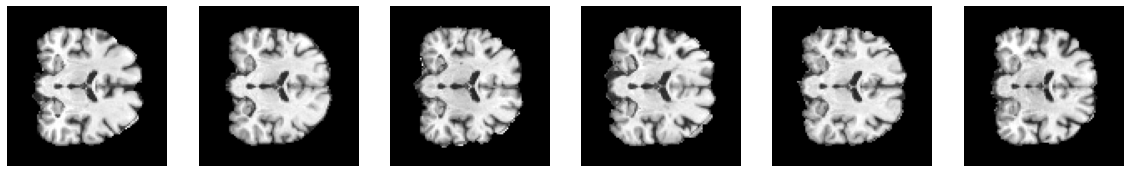

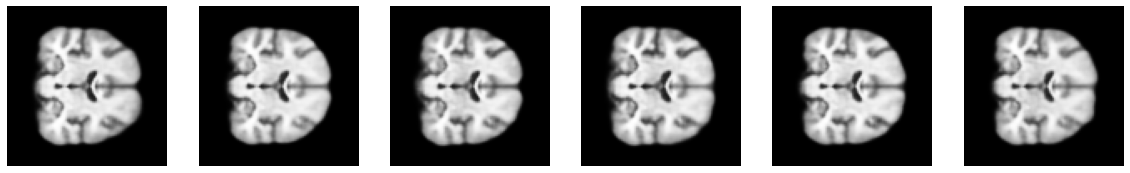

In [20]:
train_set = ADNIDataset(pd.concat((subjects,test_subjects)), train=True, modality=MODALITY)
dataloader = DataLoader(train_set, **LOADER_ARGS)
model = NetGAE().to(DEVICE)

if TRAIN_GAE and MODALITY!='cdata':
    time('Training NetAE...')
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    scheduler = CosineAnnealingWarmRestarts(optimizer,5,2,eta_min=1e-5)
    mloss = 0.2
    for epoch in range(1, EPOCHS_CAE + 1):
        loss = trainGAE(model, dataloader, optimizer, epoch)
        scheduler.step()
        if loss < mloss:
            torch.save(model.state_dict(), NETCAE_FILE)
            time('Model saved: {:6.4f}'.format(loss))
            mloss = loss
            
elif MODALITY=='cdata':
    time('Use clinical feature only, skip loading model')
    
else:
    time('NetAE Result...')
    model.load_state_dict(torch.load(NETCAE_FILE))
    validGAE(model, dataloader)

In [21]:
import time
ACC=[]
SEN=[]
SPE=[]
ACC_fold=[]
ACC_fold.append(0.928)
SEN_fold=[]
SPE_fold=[]
max_acc = 0
kfold = StratifiedKFold(n_splits=K_FOLDS, random_state=RAND_STATE, shuffle=True)
# Count reference time
sum_t=0.0
Train = True
#Train = False

for k, (train_index, valid_index) in enumerate(kfold.split(subjects,labels), 1):
    print(f'-------------------- Fold: {k}  --------------------')
    # setting train/valid/test dataset
    train_set = subjects.iloc[train_index]
    valid_set = subjects.iloc[valid_index]
    test_set  = test_subjects
        
    train_set = ADNIDataset(train_set, train=True,  modality=MODALITY)
    valid_set = ADNIDataset(valid_set, train=False, modality=MODALITY)
    test_set  = ADNIDataset(test_set,  train=False, modality=MODALITY)
        
    train_loader = DataLoader(train_set, **LOADER_ARGS)
    valid_loader = DataLoader(valid_set, **LOADER_ARGS)
    test_loader  = DataLoader(test_set,  **LOADER_ARGS)
    
    # loading model
    autoencoder = NetGAE().to(DEVICE)
    autoencoder.load_state_dict(torch.load(NETCAE_FILE))
    autoencoder.encoder[:3].requires_grad_(False)
        
    model = NetMS(autoencoder.encoder, modality=MODALITY).to(DEVICE)
    #model.load_state_dict(torch.load('MS-GAE_MMSE.pth'))
    #model.load_state_dict(torch.load('MS-GAE_CDR1.pth'))
    
    # optimizer & LR scheduler
    #optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = CosineAnnealingWarmRestarts(optimizer,5,2,eta_min=1e-5)
    
    for epoch in range(1, EPOCHS_MS + 1):
        
        if Train==True:
            record1 = trainMS(model, train_loader, optimizer, epoch)
            #if (epoch%10 == 0):
                #accuracy, Precision, recall, specificity = record1.CAL()
                #print(f'Epoch: {epoch}, Acc: {accuracy}, Sen: {recall}, Spe: {specificity}')
                
            record2= validMS(model, valid_loader, epoch)
            accuracy, Precision, recall, specificity = record2.CAL()
                
        else:
            record2= validMS(model, valid_loader, epoch)  
            accuracy, Precision, recall, specificity = record2.CAL()
            if accuracy>max_acc:
                max_acc=accuracy  
                print(f'Epoch: {epoch}, Acc: {max_acc}, Sen: {recall}, Spe: {specificity}')
                record2.plot()
                
         
        #record5, record6 = validMS(model, test_loader,  epoch)
     
        scheduler.step()
        
         
        if epoch == EPOCHS_MS:
            
            if Train and accuracy>max(ACC_fold):
                name = 'Acc='+str(round(accuracy,3))+'.pth'
                torch.save(model.state_dict(), name)
            
            ACC_fold.append(accuracy)
            SEN_fold.append(recall)
            SPE_fold.append(specificity)
            
    
    record2.plot()
    
    


-------------------- Fold: 1  --------------------


KeyboardInterrupt: 

In [7]:
import statistics
A=[0.934,0.894,0.901,0.94,0.901] 
a = statistics.mean(A)
b = statistics.stdev(A)
print(f'SEN:\nMean: {a}  Std: {b}')


SEN:
Mean: 0.914  Std: 0.02129553943904684


the model accuracy is  0.9210526315789473
+----------+-----------+--------+-------------+
|          | Precision | Recall | Specificity |
+----------+-----------+--------+-------------+
|   Low    |    1.0    | 0.978  |     1.0     |
|   Mild   |   0.957   | 0.815  |    0.992    |
| Moderate |   0.756   | 0.969  |    0.917    |
|  Severe  |   0.977   | 0.896  |     0.99    |
+----------+-----------+--------+-------------+


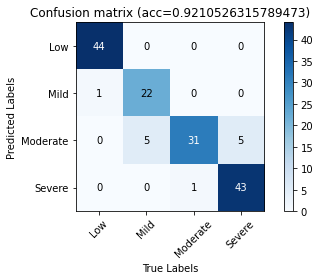

In [51]:
record2.plot()

the model accuracy is  0.9013157894736842
+----------+-----------+--------+-------------+
|          | Precision | Recall | Specificity |
+----------+-----------+--------+-------------+
|   Low    |    0.98   | 0.828  |    0.989    |
|   Mild   |   0.772   | 0.957  |    0.877    |
| Moderate |   0.978   | 0.938  |     0.99    |
+----------+-----------+--------+-------------+


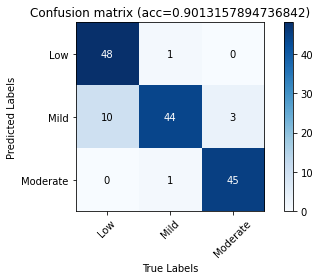

In [35]:
record2.plot()

In [ ]:
ACC
SEN
SPE
ACC_fold
SEN_fold
SPE_fold

In [123]:
ACC_fold

[]

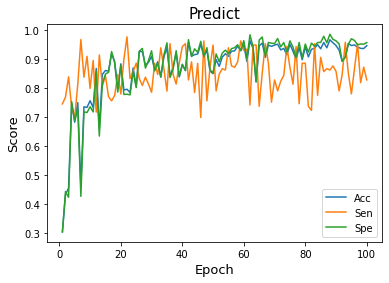

<Figure size 864x432 with 0 Axes>

In [25]:
Epoch = list(range(1,101))
plt.plot(Epoch,ACC, label = 'Acc')
plt.plot(Epoch,SEN, label = 'Sen')
plt.plot(Epoch,SPE, label = 'Spe')

plt.title("Predict",fontsize=15)
plt.xlabel("Epoch",fontsize=13)
plt.ylabel("Score",fontsize=13)
plt.legend()
plt.figure(figsize=(12,6))
plt.show()

In [32]:
import statistics
SEN_cal = SEN[40:]
a = statistics.mean(SEN_cal)
b = statistics.stdev(SEN_cal)
print(f'SEN:\nMean: {a}  Std: {b}')

SEN
Mean: 0.8584915019466907  Std: 0.07062662877241117


In [33]:
import statistics
SPE_cal = SPE[40:]
a = statistics.mean(SPE_cal)
b = statistics.stdev(SPE_cal)
print(f'SPE:\nMean: {a}  Std: {b}')

SPE
Mean: 0.9369964033718561  Std: 0.03323291923956146


In [34]:
import statistics
ACC_cal = ACC[40:]
a = statistics.mean(ACC_cal)
b = statistics.stdev(ACC_cal)
print(f'ACC:\nMean: {a}  Std: {b}')

ACC:
Mean: 0.9258630488955294  Std: 0.029494847912129054


In [14]:
max(ACC)

0.9435483870967742

In [48]:
print('ACC: ',ACC[ACC.index(max(ACC))])
print('SEN: ',SEN[ACC.index(max(ACC))])
print('SPE: ',SPE[ACC.index(max(ACC))])

ACC:  0.9956383693900197
SEN:  0.9889188379754417
SPE:  1.0


In [ ]:
autoencoder = NetCAE().to(DEVICE)
autoencoder.load_state_dict(torch.load(NETCAE_FILE))
autoencoder.encoder[:3].requires_grad_(False)
        
model = NetMS(autoencoder.encoder, modality=MODALITY).to(DEVICE)
train_set = ADNIDataset(pd.concat((subjects,test_subjects)), train=True, modality=MODALITY)
dataloader = DataLoader(train_set, **LOADER_ARGS)

for data in dataloader:
    confusion = ConfusionMatrix(num_classes=3, labels=SEV_LABEL)    
    
    cdata = torch.tensor([])
    mri, temp2, target, task = data
    
    '''
    #Construct MMSE label
    for i in range(len(target)):
        if temp2[i][11] >=26:
            target[i] = 0.0
        elif temp2[i][11] < 26 and temp2[i][11] >=21:
            target[i] = 1.0
        elif temp2[i][11] <21 and temp2[i][11]>=11:
            target[i] = 2.0

        a = temp2[i]
        a = a[:-1] 
        cdata = torch.cat((cdata,a),0)
    cdata = cdata.resize(BATCH_SIZE,11)
    
    '''
    #Construct CDR label
    for i in range(len(target)):
        if temp2[i][4] <= 0.08:
            target[i] = 0.0
            b+=1
        elif temp2[i][4]>0.08 and temp2[i][4]<=0.18:
            target[i] = 1.0
            c+=1
        else:
            target[i] = 2.0
            d+=1
        a = temp2[i]
        a = a[:-1]
        cdata = torch.cat((cdata,a),0)     
    cdata = cdata.resize(BATCH_SIZE,11) 
    
    
    mri, cdata, target = mri.to(DEVICE), cdata.to(DEVICE), target.to(DEVICE)
    
    t1_index = np.argwhere(task==1).reshape(-1)
    t2_index = np.argwhere(task==2).reshape(-1)
    
    out1, out2 = model(mri, cdata)
    
    out1 = out1[t1_index]
    out2 = out2[t2_index]
    target1 = target[t1_index].long()
    target2 = target[t2_index].long()
    
    out = torch.cat((out1,out2),0)
    target = torch.cat((target1,target2),0)
    
    
    ret, predictions = torch.max(out.data, 1)
    for p, t in zip(predictions.cpu().numpy(), target.cpu().numpy()):
        print(p,t)
    
    #confusion.update(predictions.cpu().numpy(), target.cpu().numpy())
    
    loss = LOSS_FUNC(out, target)
    
    break

In [17]:
b=0
c=0
d=0
s=[]
for data in train_loader: 
    cdata = torch.tensor([])
    mri, temp2, target, task = data   
    '''
    #Construct CDR label
    for i in range(len(target)):
        if temp2[i][4] <= 0.1:
            target[i] = 0.0
            b+=1
        elif temp2[i][4]>0.1 and temp2[i][4]<=0.2:
            target[i] = 1.0
            c+=1
        else:
            target[i] = 2.0
            d+=1
        a = temp2[i]
        a = a[:-1]
        cdata = torch.cat((cdata,a),0)     
    cdata = cdata.resize(BATCH_SIZE,11) 
    '''
    #Construct MMSE label
    for i in range(len(target)):
        if temp2[i][11] >=29:
            target[i] = 0.0
            b+=1
        elif temp2[i][11] < 29 and temp2[i][11] >=26:
            target[i] = 1.0
            c+=1
        else:
            target[i] = 2.0
            d+=1         
        a = temp2[i]
        a = a[:-1] 
        cdata = torch.cat((cdata,a),0)
    cdata = cdata.resize(BATCH_SIZE,11)
    
    for i in range(len(target)):
        s.append(temp2[i][11])


print(b)
print(c)
print(d)


211
228
185


In [137]:
print(sorted(s))

[tensor(24.), tensor(24.), tensor(24.), tensor(24.), tensor(25.), tensor(25.), tensor(25.), tensor(25.), tensor(25.), tensor(25.), tensor(26.), tensor(26.), tensor(27.), tensor(27.), tensor(27.), tensor(27.), tensor(27.), tensor(27.), tensor(27.), tensor(27.), tensor(28.), tensor(28.), tensor(28.), tensor(28.), tensor(28.), tensor(28.), tensor(29.), tensor(29.), tensor(29.), tensor(30.), tensor(30.), tensor(30.)]


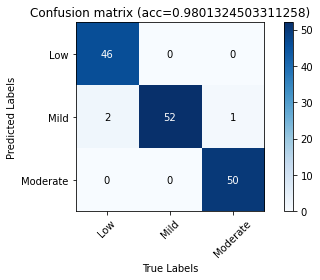

In [169]:
num_classes = 3
labels=SEV_LABEL
matrix = np.array([[46, 0, 0], [2, 52, 1], [0, 0, 50]])
plt.imshow(matrix, cmap=plt.cm.Blues)
sum_TP = 0
n = np.sum(matrix)
for i in range(num_classes):
    sum_TP += matrix[i, i]
acc = str(sum_TP / n)
plt.xticks(range(num_classes), labels, rotation=45)
plt.yticks(range(num_classes), labels)

plt.colorbar()
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion matrix (acc='+acc+')')


thresh = matrix.max() / 2
for x in range(num_classes):
    for y in range(num_classes):
        info = int(matrix[y, x])
        plt.text(x, y, info, verticalalignment='center', horizontalalignment='center', color="white" if info > thresh else "black")
plt.tight_layout()
plt.show()

the model accuracy is  0.9801324503311258
+----------+-----------+--------+-------------+
|          | Precision | Recall | Specificity |
+----------+-----------+--------+-------------+
|   Low    |    1.0    | 0.958  |     1.0     |
|   Mild   |   0.945   |  1.0   |     0.97    |
| Moderate |    1.0    |  0.98  |     1.0     |
+----------+-----------+--------+-------------+


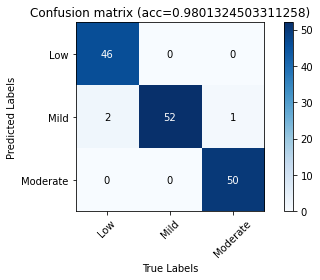

In [37]:
a=0
b=0
myrecord = ConfusionMatrix(num_classes=3, labels=SEV_LABEL)
myrecord.update(a,b)
myrecord.plot()

In [29]:
import torchvision.models as models
model1 = NetMS(autoencoder.encoder, modality=MODALITY)
model2 = NetGAE()
p1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
p2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
res = p1+p2

In [30]:
print(f'Para: {res/1e6}M')

Para: 0.781274M


In [66]:
from torchvision.models import resnet50 
from thop import profile
model = NetMS(autoencoder.encoder, modality=MODALITY).to(DEVICE)
input=torch.randn(8,1,96,96,96).to(DEVICE)
cdata=torch.randn(8,11).to(DEVICE)
macs, params = profile(model, inputs=(input, cdata), verbose=False)
print(f"macs = {macs/1e9}G")
print(f"params = {params/1e6}M")

macs = 185.105225472G
params = 0.367032M
